<a href="https://colab.research.google.com/github/ThierrryScotto/cais_maua/blob/main/up_to_date_cais_maua_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install --quiet pmdarima

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

# Getting the data

In [5]:
url = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/datasetInterpolate.csv"

dataset = pd.read_csv(url, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227,23.1
1,2014-07-29 13:45:00,0.0,227,23.1
2,2014-07-29 14:00:00,0.0,227,23.1
3,2014-07-29 14:15:00,0.0,225,23.1
4,2014-07-29 14:30:00,0.0,223,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260,19.0
346503,2024-06-15 23:15:00,0.0,261,19.0
346504,2024-06-15 23:30:00,0.2,261,19.0
346505,2024-06-15 23:45:00,0.0,262,19.0


In [6]:
url_2 = "https://raw.githubusercontent.com/ThierrryScotto/cais_maua/main/datasets/CausMauaSemTratamento.csv"

dataset_missing_data = pd.read_csv(url_2, names=['date_time', 'mm/h', 'level_cm', 'temperature'])
dataset_missing_data

,date_time,mm/h,level_cm,temperature
0,2014-07-29 13:30:00,0.0,227.0,23.1
1,2014-07-29 13:45:00,0.0,227.0,23.1
2,2014-07-29 14:00:00,0.0,227.0,23.1
3,2014-07-29 14:15:00,0.0,225.0,23.1
4,2014-07-29 14:30:00,0.0,223.0,24.1
...,...,...,...,...
346502,2024-06-15 23:00:00,0.0,260.0,19.0
346503,2024-06-15 23:15:00,0.0,261.0,19.0
346504,2024-06-15 23:30:00,0.2,261.0,19.0
346505,2024-06-15 23:45:00,0.0,262.0,19.0


In [7]:
dataset.drop(columns=["temperature", "mm/h"], inplace=True)
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


# Data Preparation

In [8]:
FIGSIZE = (20, 20)

In [9]:
def plot_dataset(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=figsize, dpi=dpi)
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [10]:
def plot_dataset_scatter(x, y, x_label, y_label, title, figsize=FIGSIZE, dpi=90):
  plt.figure(figsize=(12, 10), dpi=90)
  plt.scatter(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

In [11]:
dataset.shape

(346507, 2)

In [12]:
dataset

,date_time,level_cm
0,2014-07-29 13:30:00,227
1,2014-07-29 13:45:00,227
2,2014-07-29 14:00:00,227
3,2014-07-29 14:15:00,225
4,2014-07-29 14:30:00,223
...,...,...
346502,2024-06-15 23:00:00,260
346503,2024-06-15 23:15:00,261
346504,2024-06-15 23:30:00,261
346505,2024-06-15 23:45:00,262


In [13]:
dataset.describe()

,level_cm
count,346507.000000
mean,167.413221
std,55.444910
min,63.000000
25%,133.000000
50%,157.000000
75%,186.000000
max,535.000000


In [14]:
dataset.isnull().sum()

,0
date_time,0
level_cm,0


In [15]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])
dataset.set_index('date_time', inplace=True)

dataset

,level_cm
date_time,
2014-07-29 13:30:00,227
2014-07-29 13:45:00,227
2014-07-29 14:00:00,227
2014-07-29 14:15:00,225
2014-07-29 14:30:00,223
...,...
2024-06-15 23:00:00,260
2024-06-15 23:15:00,261
2024-06-15 23:30:00,261


In [16]:
dataset.dtypes

,0
level_cm,int64


checking for negatives values

In [17]:
# Localizar valores negativos
def check_negatives_values(dataset):
    negatives_exist = (dataset < 0).any().any()

    if negatives_exist:
        print("There are negative values in the dataset.")
    else:
        print("There are no negative values in the dataset.")

# Time Series EDA

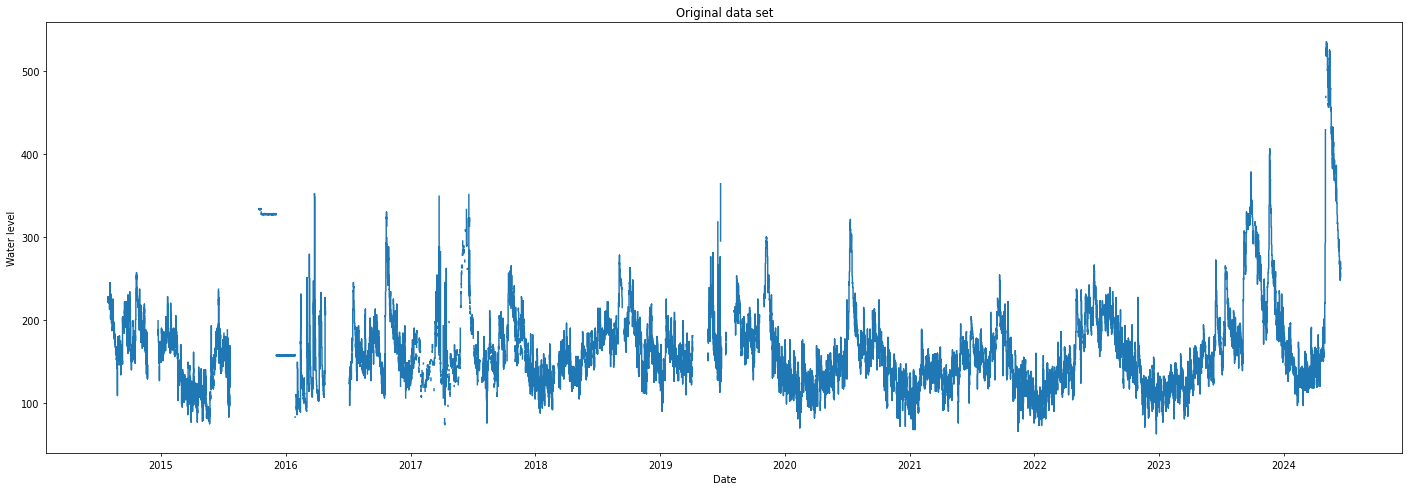

In [18]:
dataset_missing_data['date_time'] = pd.to_datetime(dataset_missing_data['date_time'])
dataset_missing_data.set_index('date_time', inplace=True)

plot_dataset(dataset_missing_data.index.date, dataset_missing_data['level_cm'], 'Date', 'Water level', f'Original data set', figsize=(25, 8), dpi=70)

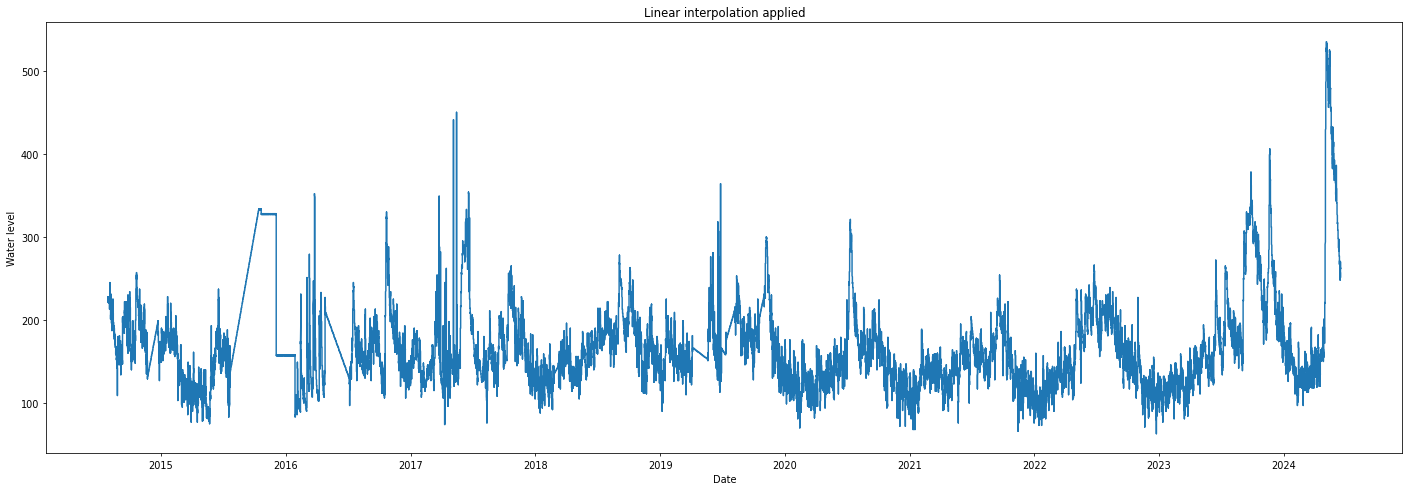

In [19]:
plot_dataset(dataset.index.date, dataset['level_cm'], 'Date', 'Water level', f'Linear interpolation applied', figsize=(25, 8), dpi=70)

### Selecting time

In [20]:
# Definir a faixa de datas
start_date = '2019-08-01'

# Selecionar os dados dentro da faixa de datas
df_filtered = dataset[start_date:]

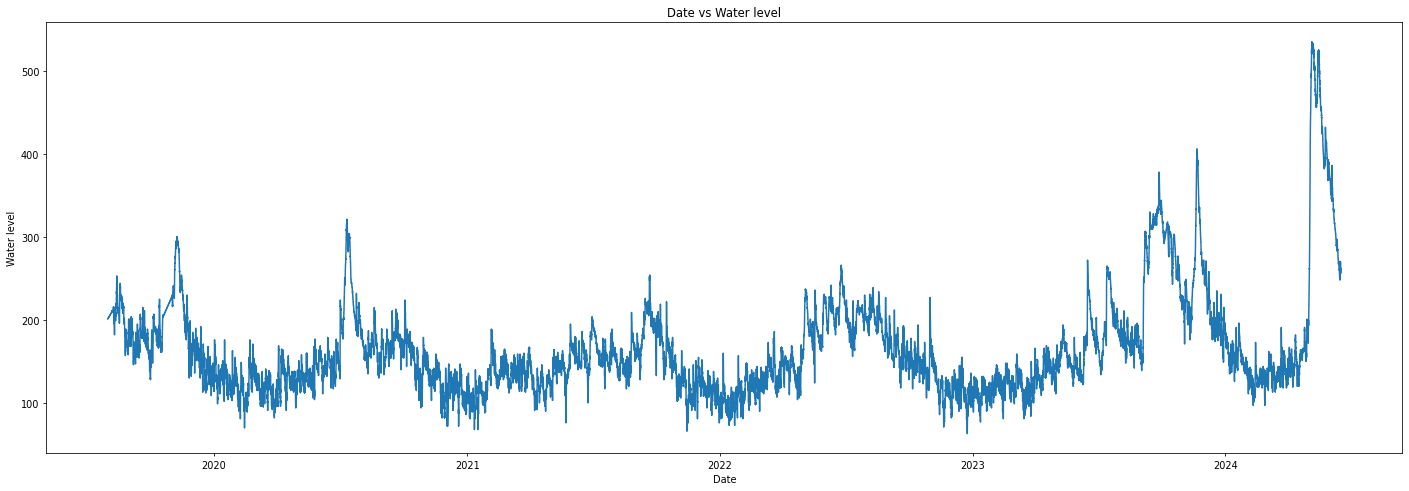

In [21]:
plot_dataset(df_filtered.index, df_filtered['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

### Grouping the data by day

In [22]:
df_daily_mean = df_filtered.resample('D').mean()
df_daily_mean

,level_cm
date_time,
2019-08-01,202.208333
2019-08-02,203.541667
2019-08-03,204.968750
2019-08-04,206.427083
2019-08-05,207.729167
...,...
2024-06-12,270.854167
2024-06-13,263.791667
2024-06-14,252.802083


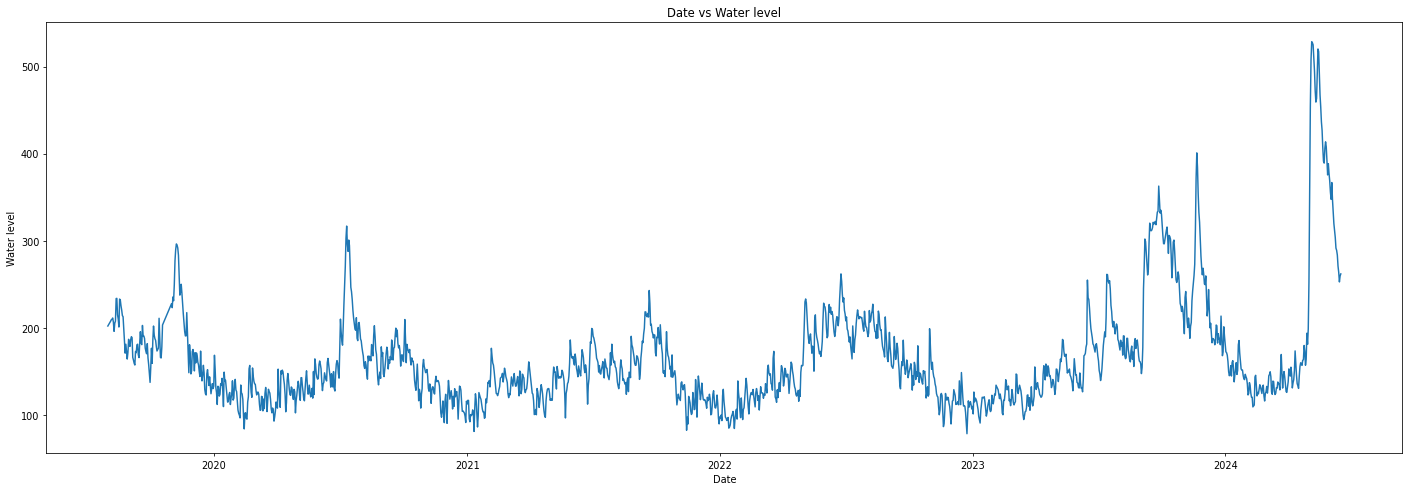

In [23]:
plot_dataset(df_daily_mean.index, df_daily_mean['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

## Time Series Decomposition

In [24]:
['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

['mm/h_lag_1', 'level_cm_lag_1', 'temperature_lag_1']

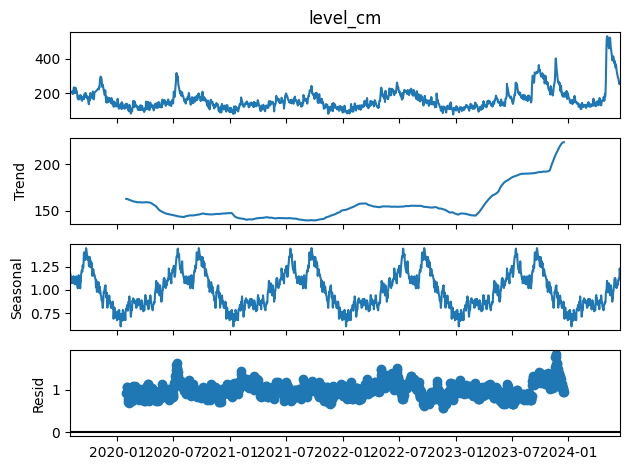

In [25]:
result = seasonal_decompose(df_daily_mean['level_cm'], model='multiplicative', period=365)
result.plot()
plt.show()

<Axes: xlabel='date_time'>

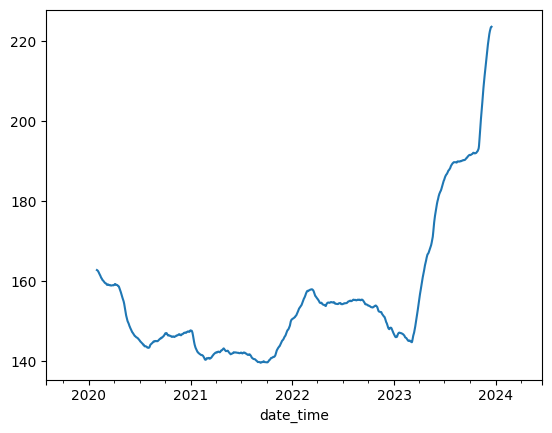

In [26]:
result.trend.plot()

<Axes: xlabel='date_time'>

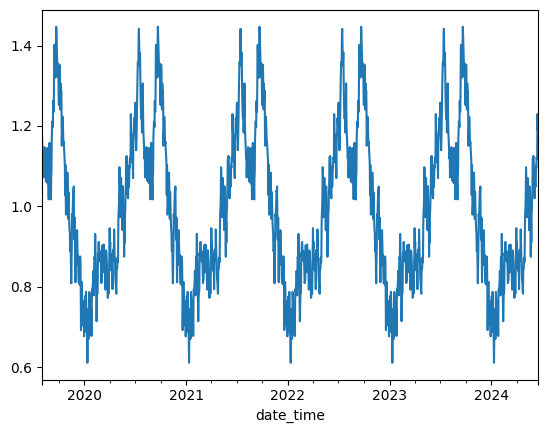

In [27]:
result.seasonal.plot()

<Axes: xlabel='date_time'>

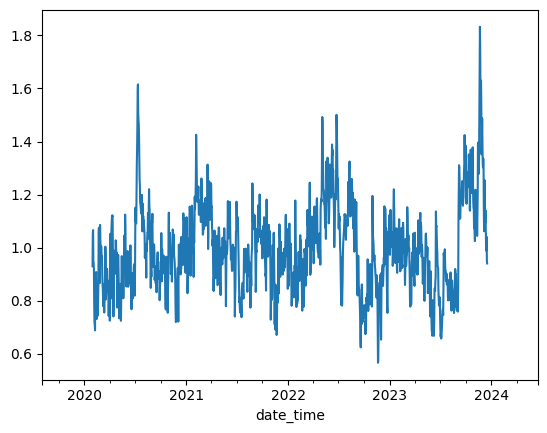

In [28]:
residual = result.resid
residual.plot()

## Making the series stationary

In [29]:
def plot_autocorrelation(value, lags=1):
  plot_acf(value, lags=lags)
  plot_pacf(value, lags=lags, method = "ols")

Dickey–Fuller test

In [30]:
def check_stationarity(df):
  result = adfuller(df)

  print('-- Dickey–Fuller test --')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical values: ')
  for key, value in result[4].items():
    print('\t%s: %3f' % (key, value))
print('\n\n')

### Checking for stationarity

In [31]:
print("Level_cm")
check_stationarity(df_daily_mean['level_cm'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -4.519272
p-value: 0.000181
Critical values: 
	1%: -3.434031
	5%: -2.863166
	10%: -2.567636


### Transforming data using differentiation

In [32]:
df_lag = pd.DataFrame()

df_lag['level_cm_lag_1'] = df_daily_mean['level_cm'] - df_daily_mean['level_cm'].shift(1)

df_lag.dropna(inplace=True)
df_lag

,level_cm_lag_1
date_time,
2019-08-02,1.333333
2019-08-03,1.427083
2019-08-04,1.458333
2019-08-05,1.302083
2019-08-06,1.645833
...,...
2024-06-12,-12.781250
2024-06-13,-7.062500
2024-06-14,-10.989583


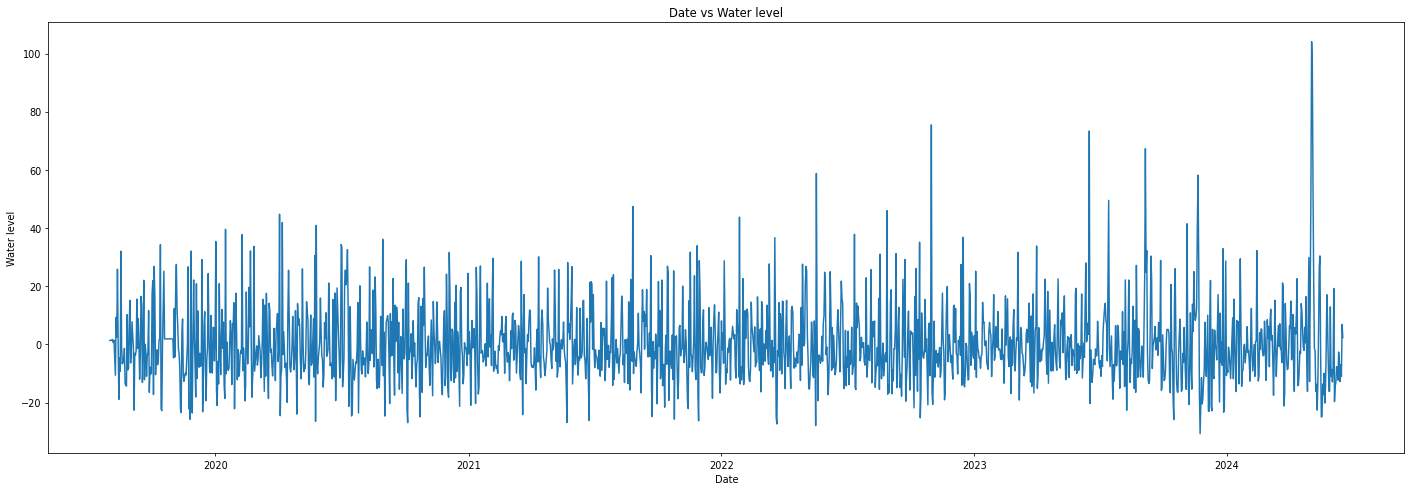

In [33]:
plot_dataset(df_lag.index, df_lag['level_cm_lag_1'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [34]:
print("Level_cm")
check_stationarity(df_lag['level_cm_lag_1'])

Level_cm
-- Dickey–Fuller test --
ADF Statistic: -31.657542
p-value: 0.000000
Critical values: 
	1%: -3.434031
	5%: -2.863166
	10%: -2.567636


**Using ACF and PACF level_cm**

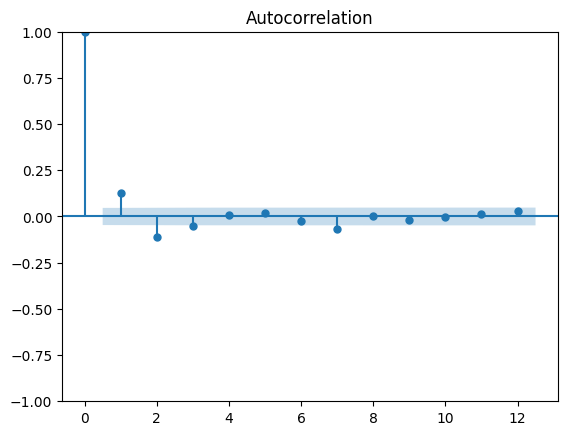

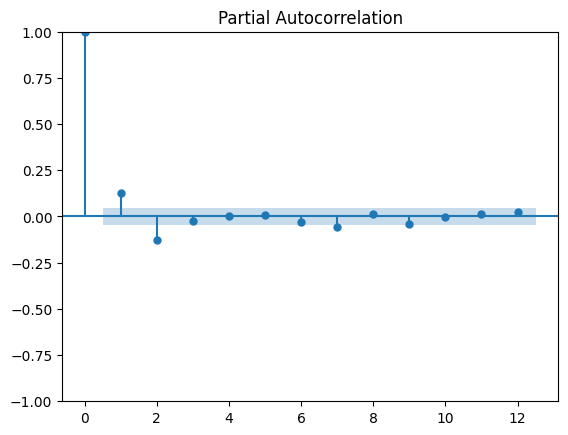

In [35]:
plot_acf(df_lag['level_cm_lag_1'], lags=12)
plot_pacf(df_lag['level_cm_lag_1'], lags=12, method="ols")
plt.show()

In [36]:
check_negatives_values(df_lag['level_cm_lag_1'])

There are negative values in the dataset.


### Log transformation

In [37]:
dataset_log = np.log(df_daily_mean['level_cm'])
dataset_log = dataset_log.diff().dropna()

dataset_log

,level_cm
date_time,
2019-08-02,0.006572
2019-08-03,0.006987
2019-08-04,0.007090
2019-08-05,0.006288
2019-08-06,0.007892
...,...
2024-06-12,-0.046109
2024-06-13,-0.026421
2024-06-14,-0.042553


In [38]:
dataset_log = pd.DataFrame()

dataset_log['level_cm'] = np.log(df_daily_mean['level_cm'])

dataset_log.dropna(inplace=True)
dataset_log

,level_cm
date_time,
2019-08-01,5.309299
2019-08-02,5.315871
2019-08-03,5.322858
2019-08-04,5.329947
2019-08-05,5.336235
...,...
2024-06-12,5.601581
2024-06-13,5.575160
2024-06-14,5.532607


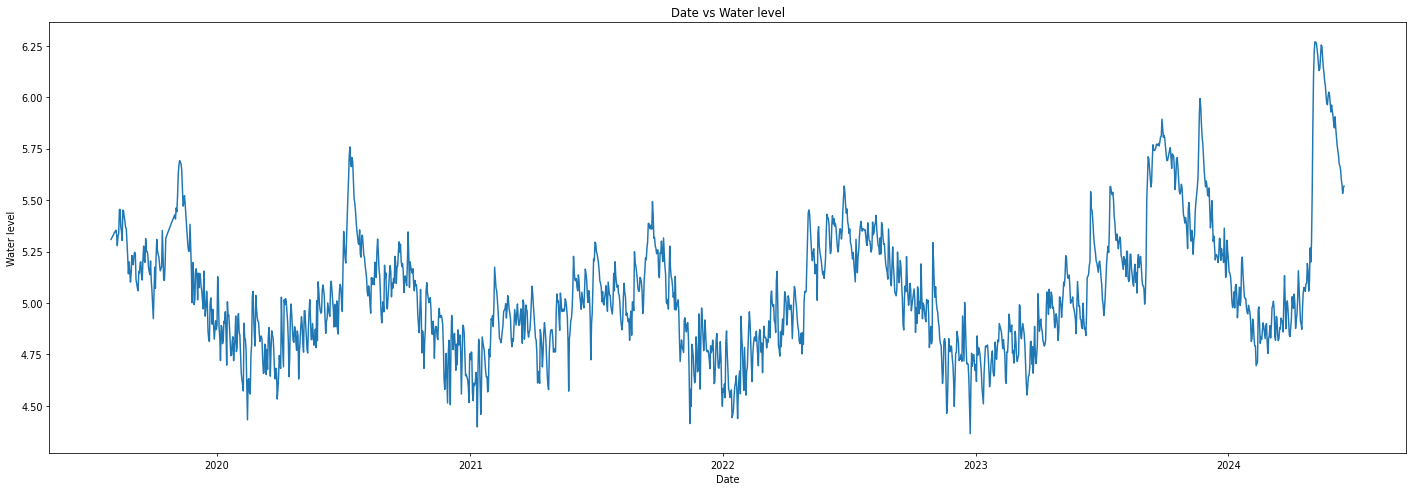

In [39]:
plot_dataset(dataset_log.index, dataset_log['level_cm'], 'Date', 'Water level', f'Date vs Water level', figsize=(25, 8), dpi=70)

#### Checking transformed data

In [40]:
check_stationarity(dataset_log['level_cm'])

-- Dickey–Fuller test --
ADF Statistic: -3.794317
p-value: 0.002966
Critical values: 
	1%: -3.434042
	5%: -2.863171
	10%: -2.567638


**Using ACF and PACF level_cm**

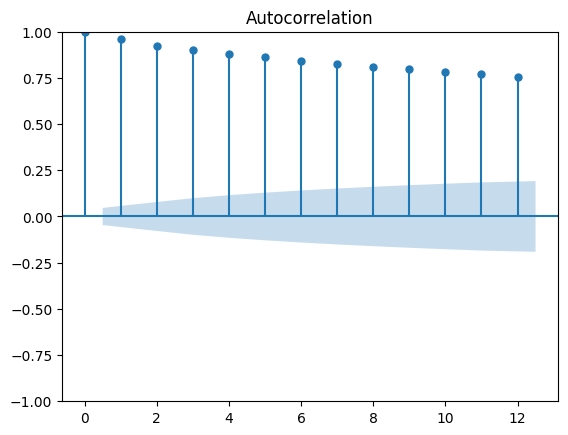

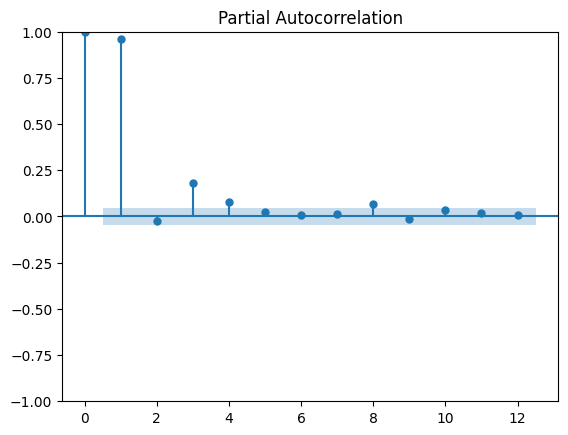

In [41]:
plot_acf(dataset_log['level_cm'], lags=12)
plot_pacf(dataset_log['level_cm'], lags=12, method="ols")
plt.show()

In [42]:
check_negatives_values(dataset_log['level_cm'])

There are no negative values in the dataset.


# Training the model

## Scaling the data

In [43]:
data = dataset_log['level_cm'].values
data

array([5.30929852, 5.31587073, 5.32285753, ..., 5.5326069 , 5.5592784 ,
       5.5683445 ])

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(dataset_log).flatten()
data_scaled

array([0.49577601, 0.49922542, 0.50289243, ..., 0.61297896, 0.62697744,
       0.63173577])

In [45]:
df_scaled = pd.DataFrame()
df_scaled['level_cm_lag_1_scaled'] = data_scaled
df_scaled.index = dataset_log.index
df_scaled

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2024-06-12,0.649180
2024-06-13,0.635313
2024-06-14,0.612979


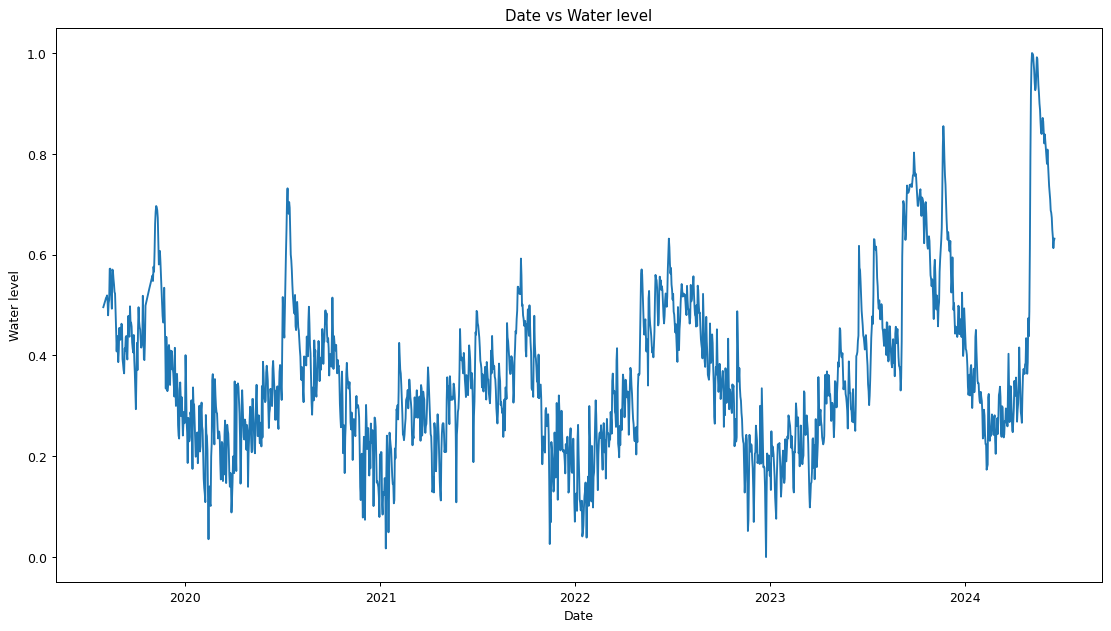

In [46]:
plot_dataset(df_scaled.index, df_scaled['level_cm_lag_1_scaled'], 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [47]:
start_date_train = '2023-01-01'

df_train = df_scaled[:start_date_train]
df_test = df_scaled[start_date_train:]

train_size = len(df_train)
test_size = len(df_test)

print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  1250
Test size:  533


In [48]:
# 67%
df_scaled.head(1091)

# 70% --> selecionado
df_scaled.head(1139)

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2022-09-08,0.351734
2022-09-09,0.369365
2022-09-10,0.463437


In [49]:
df_train

,level_cm_lag_1_scaled
date_time,
2019-08-01,0.495776
2019-08-02,0.499225
2019-08-03,0.502892
2019-08-04,0.506613
2019-08-05,0.509914
...,...
2022-12-28,0.191763
2022-12-29,0.201704
2022-12-30,0.184181


In [50]:
df_test = df_test.drop(df_test.index[0])
df_test

,level_cm_lag_1_scaled
date_time,
2023-01-02,0.133113
2023-01-03,0.249506
2023-01-04,0.200187
2023-01-05,0.219898
2023-01-06,0.214659
...,...
2024-06-12,0.649180
2024-06-13,0.635313
2024-06-14,0.612979


## AUTO ARIMA

In [ ]:
# Ajustar o modelo auto_arima
model = auto_arima(df_train,
                   start_p=1,
                   start_q=1,
                   max_p=2,
                   max_q=2,
                   start_P=1,
                   start_Q=1,
                   D=0,
                   max_P=3,
                   max_D=3,
                   max_Q=3,
                   max_order=5,
                   m=365,
                   seasonal=True,
                   stepwise=True,
                   trace=True)

# Imprimir o resumo do modelo
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[365] intercept   : AIC=inf, Time=1754.89 sec
 ARIMA(0,0,0)(0,0,0)[365] intercept   : AIC=-2063.844, Time=0.14 sec


KeyboardInterrupt: 

In [ ]:
n_periods = len(df_test)  # número de períodos para prever
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast

In [ ]:
forecast.values

In [ ]:
plot_dataset(df_test.index, forecast.values, 'Date', 'Water level', f'Date vs Water level', figsize=(15, 8), dpi=90)

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, df_test['level_cm_lag_1_scaled'])
plt.plot(df_test.index, forecast.values, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Undoing the scale transformation

In [ ]:
forecast = forecast.values
test_data = np.array(df_test['level_cm_lag_1_scaled'])

forecast_inversed = scaler.inverse_transform(forecast.reshape(0, 1))
test_inversed = scaler.inverse_transform(test_data.reshape(0, 1))

In [ ]:
plt.figure(figsize=(19, 4))
plt.plot(df_test.index, test_inversed)
plt.plot(df_test.index, forecast_inversed, 'red')
plt.legend(["Forecast", "Origin"])
plt.xlabel("Years")
plt.title("Forecast using ARIMA - Test")

### Calculating error

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
print("MSE: ", mean_squared_error(test_inversed, forecast_inversed))

In [ ]:
print("RMSE: ", root_mean_squared_error(test_inversed, forecast_inversed))

##LSTM - TATP

### Stationary data

In [51]:
data_scaled = data_scaled.reshape(-1, 1)
data_scaled.shape

(1782, 1)

In [52]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [53]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [54]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [55]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.49577601 0.49922542 0.50289243 0.50661345 0.50991364] 0.5140556135705929
[0.49922542 0.50289243 0.50661345 0.50991364 0.51405561] 0.5156199901797716
[0.50289243 0.50661345 0.50991364 0.51405561 0.51561999] 0.5191228816950013
[0.50661345 0.50991364 0.51405561 0.51561999 0.51912288] 0.5073015996955657
[0.50991364 0.51405561 0.51561999 0.51912288 0.5073016 ] 0.47966020539250653


In [56]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [57]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [58]:
trainX.shape

(1419, 5)

In [59]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1419, 5, 1)

In [60]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(4, activation='tanh', input_shape=(look_back, 1),  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1419/1419 - 4s - 3ms/step - loss: 0.0139 - mean_squared_error: 0.0128 - val_loss: 0.0124 - val_mean_squared_error: 0.0116
Epoch 2/20
1419/1419 - 2s - 2ms/step - loss: 0.0059 - mean_squared_error: 0.0052 - val_loss: 0.0086 - val_mean_squared_error: 0.0080
Epoch 3/20
1419/1419 - 3s - 2ms/step - loss: 0.0051 - mean_squared_error: 0.0046 - val_loss: 0.0074 - val_mean_squared_error: 0.0069
Epoch 4/20
1419/1419 - 3s - 2ms/step - loss: 0.0043 - mean_squared_error: 0.0038 - val_loss: 0.0091 - val_mean_squared_error: 0.0087
Epoch 5/20
1419/1419 - 2s - 2ms/step - loss: 0.0043 - mean_squared_error: 0.0039 - val_loss: 0.0062 - val_mean_squared_error: 0.0058
Epoch 6/20
1419/1419 - 2s - 2ms/step - loss: 0.0042 - mean_squared_error: 0.0038 - val_loss: 0.0054 - val_mean_squared_error: 0.0051
Epoch 7/20
1419/1419 - 2s - 2ms/step - loss: 0.0040 - mean_squared_error: 0.0036 - val_loss: 0.0048 - val_mean_squared_error: 0.0044
Epoch 8/20
1419/1419 - 2s - 2ms/step - loss: 0.0039 - mean_squared_er

Predição

In [62]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [63]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [64]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 MSE
Test Score: 0.10 RMSE


In [65]:
index_train = np.arange(0, len(trainPredict))
index_train_normal = np.arange(0, len(trainY))
index_test_normal = np.arange(0, len(testY))
index_test = np.arange(0, len(testPredict))

Text(0.5, 1.0, 'Forecast using Train data')

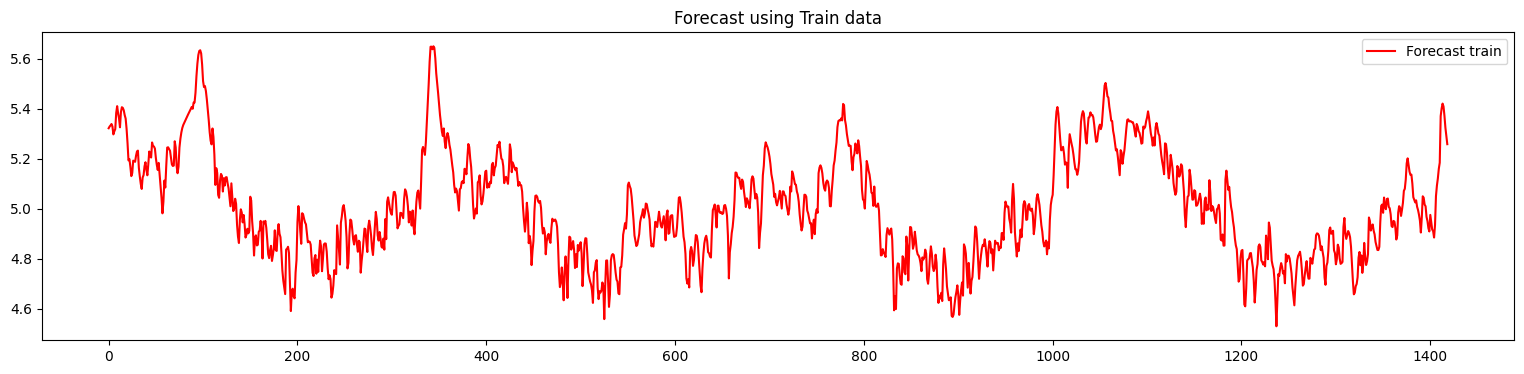

In [66]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, trainPredict, 'red')
plt.legend(["Forecast train"])
plt.title("Forecast using Train data")

Text(0.5, 1.0, 'Forecast using test data')

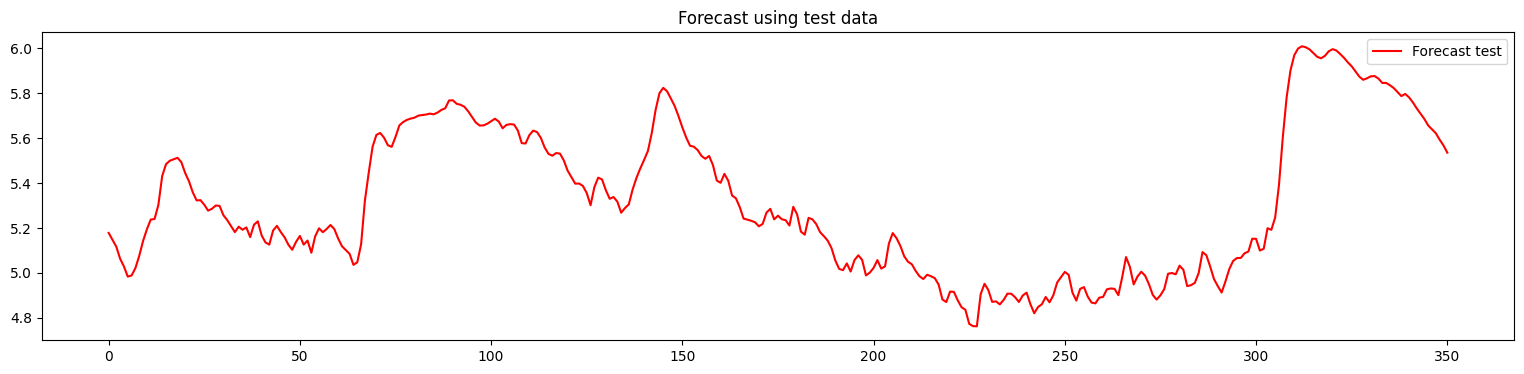

In [67]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, testPredict, 'red')
plt.legend(["Forecast test"])
plt.title("Forecast using test data")

Shift the predictions

In [68]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

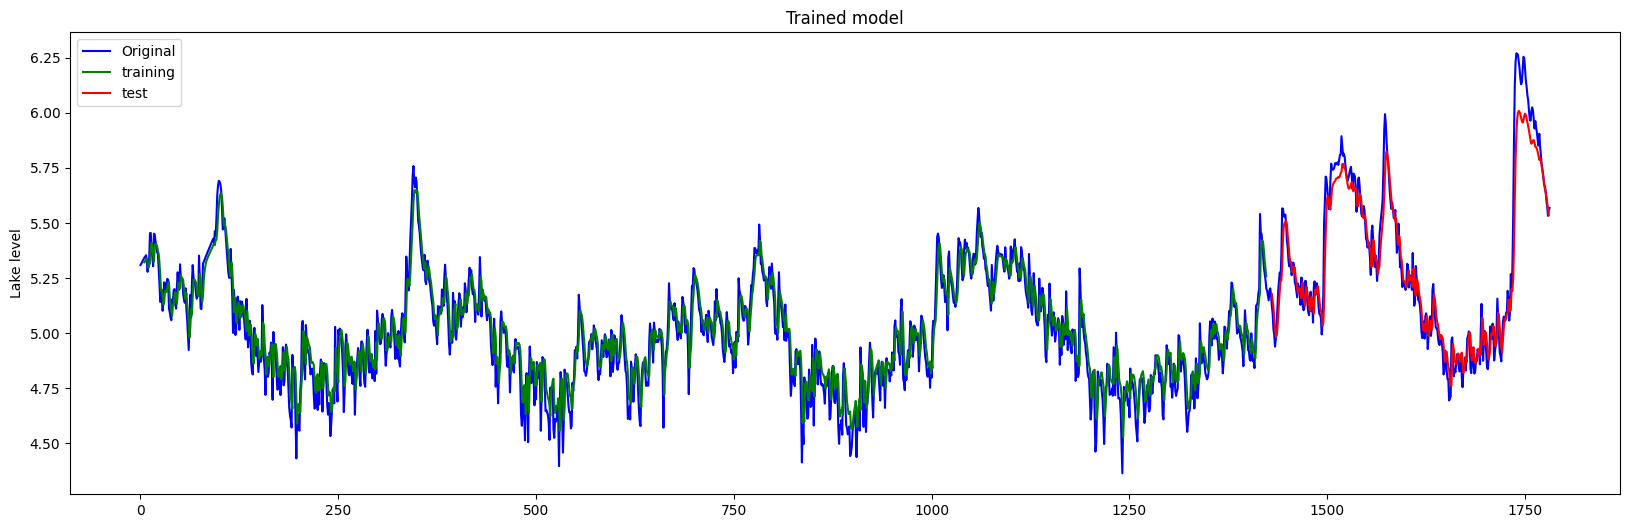

In [69]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

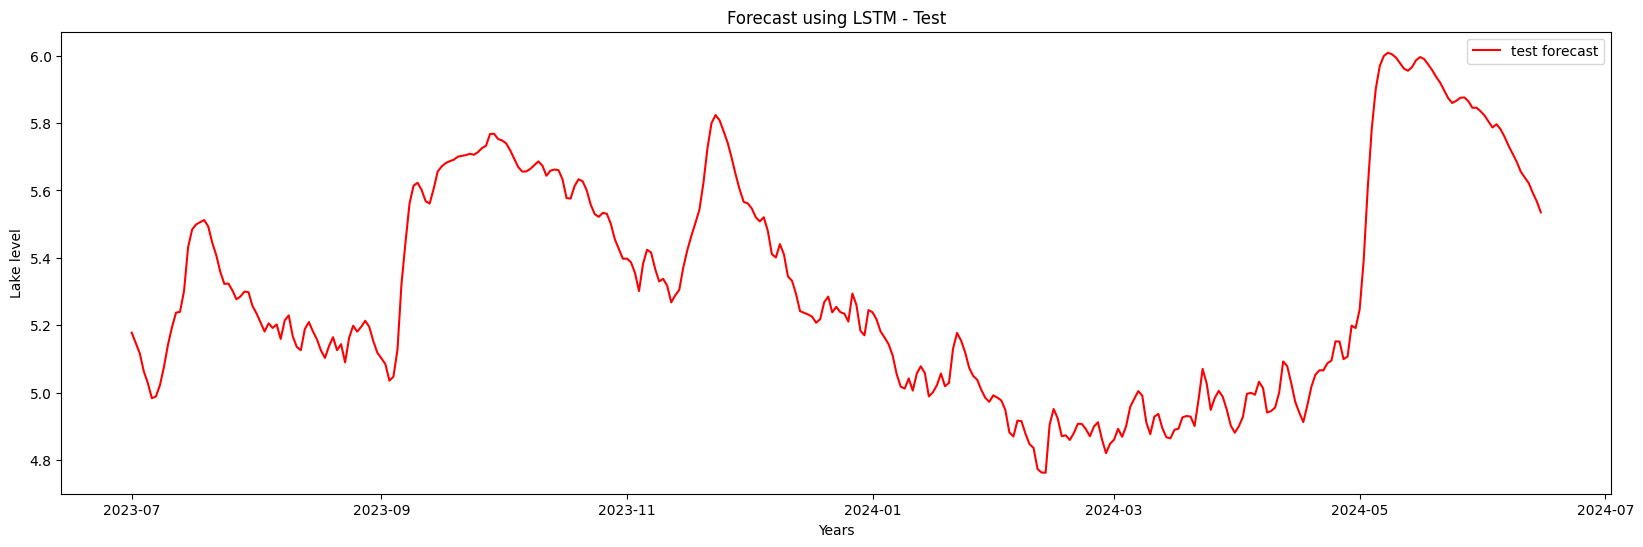

In [70]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(df_daily_mean.index, testPredictPlot, color='red')
plt.legend(["test forecast"])
plt.xlabel("Years")
plt.ylabel("Lake level")
plt.title("Forecast using LSTM - Test")
plt.show()

Prediction

### Non-stationary data

In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_daily_mean.values)
data_scaled

array([[0.27471866],
       [0.27768258],
       [0.28085491],
       ...,
       [0.38718566],
       [0.40237577],
       [0.4076321 ]])

In [72]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [73]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [74]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [75]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.27471866 0.27768258 0.28085491 0.2840967  0.28699115] 0.29064974760339
[0.27768258 0.28085491 0.2840967  0.28699115 0.29064975] 0.2920390867410735
[0.28085491 0.2840967  0.28699115 0.29064975 0.29203909] 0.29516509980086136
[0.2840967  0.28699115 0.29064975 0.29203909 0.2951651 ] 0.28469874496364556
[0.28699115 0.29064975 0.29203909 0.2951651  0.28469874] 0.2611262909276154


In [76]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [77]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [78]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1419, 5, 1)

In [79]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(LSTM(4, activation='tanh', input_shape=(look_back, 1),  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1419/1419 - 4s - 3ms/step - loss: 0.0047 - mean_squared_error: 0.0042 - val_loss: 0.0122 - val_mean_squared_error: 0.0118
Epoch 2/20
1419/1419 - 3s - 2ms/step - loss: 0.0023 - mean_squared_error: 0.0019 - val_loss: 0.0086 - val_mean_squared_error: 0.0082
Epoch 3/20
1419/1419 - 2s - 2ms/step - loss: 0.0022 - mean_squared_error: 0.0018 - val_loss: 0.0085 - val_mean_squared_error: 0.0082
Epoch 4/20
1419/1419 - 3s - 2ms/step - loss: 0.0020 - mean_squared_error: 0.0017 - val_loss: 0.0076 - val_mean_squared_error: 0.0073
Epoch 5/20
1419/1419 - 2s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0017 - val_loss: 0.0084 - val_mean_squared_error: 0.0081
Epoch 6/20
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0016 - val_loss: 0.0086 - val_mean_squared_error: 0.0083
Epoch 7/20
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0016 - val_loss: 0.0073 - val_mean_squared_error: 0.0071
Epoch 8/20
1419/1419 - 2s - 2ms/step - loss: 0.0018 - mean_squared_er

Predição

In [81]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


invert predictions

In [82]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

shift data

In [83]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

Accuracy

In [84]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.55 MSE
Test Score: 26.84 RMSE


####Plot results

In [85]:
def plot_result(dataset, predict, size, title, legend_1, legend_2, color_1 = 'royalblue', color_2 = 'orangered', linestyle_1 = '-', linestyle_2 = '--'):
    plt.figure(figsize=(19, 4))
    plt.plot(dataset.tail(size).index, dataset.tail(size)['level_cm'], color=color_1, linestyle=linestyle_1)
    plt.plot(dataset.tail(size).index, predict[-size:], color=color_2, linestyle=linestyle_2)
    plt.legend([legend_1, legend_2])
    plt.title(title)

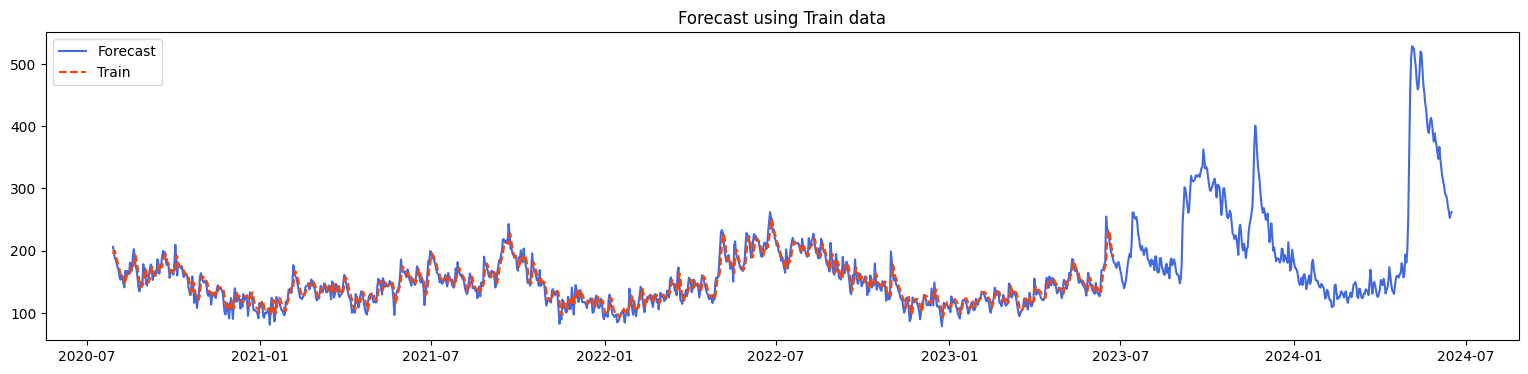

In [86]:
plot_result(df_daily_mean,
            trainPredictPlot,
            trainPredict.shape[0],
            "Forecast using Train data",
            "Forecast",
            "Train")

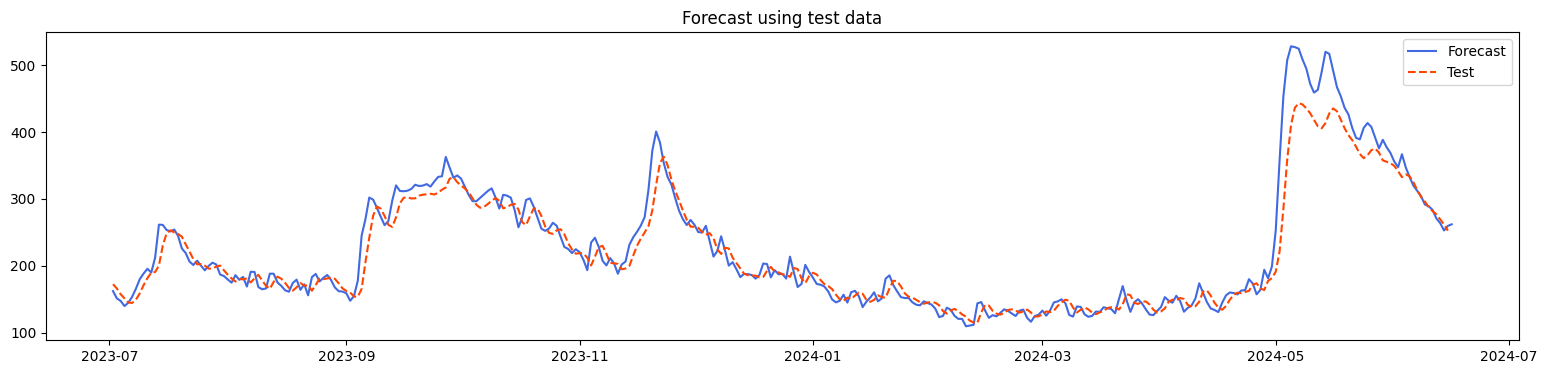

In [87]:
plot_result(df_daily_mean,
            testPredictPlot,
            testPredict.shape[0],
            "Forecast using test data",
            "Forecast",
            "Test")

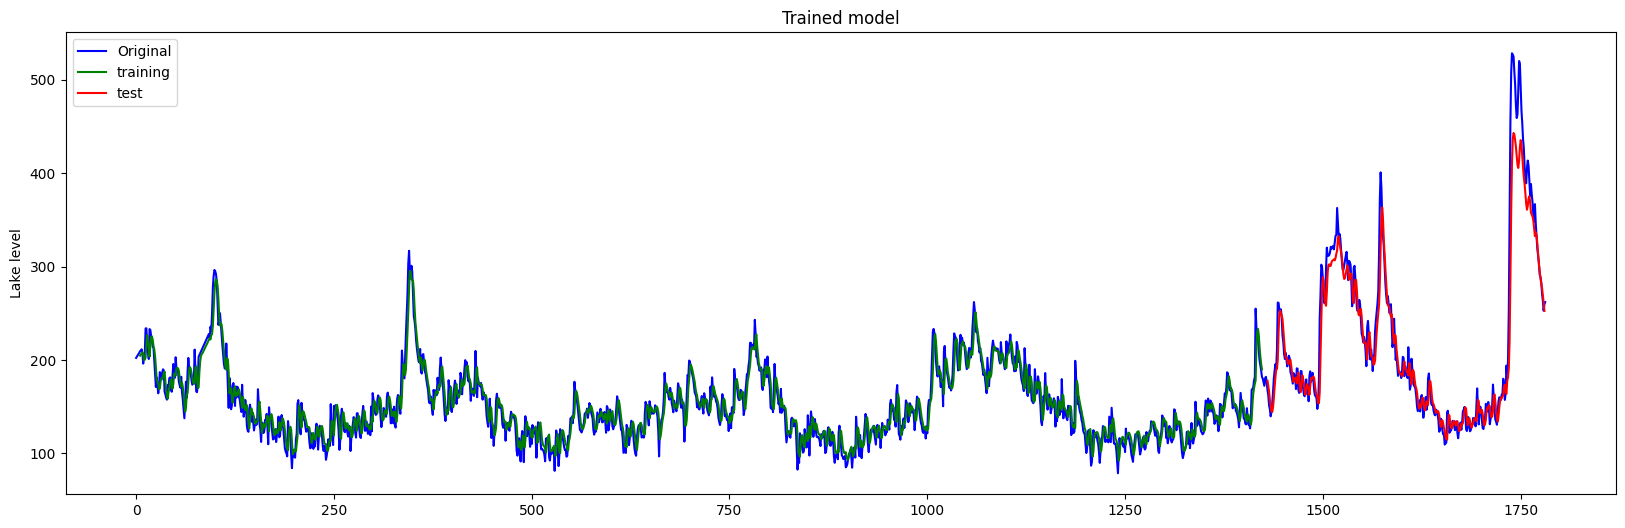

In [88]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

####Predição

##GRU - TATP

###Stationary data

In [89]:
data_scaled = data_scaled.reshape(-1, 1)
data_scaled.shape

(1782, 1)

In [90]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [91]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [92]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [93]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.27471866 0.27768258 0.28085491 0.2840967  0.28699115] 0.29064974760339
[0.27768258 0.28085491 0.2840967  0.28699115 0.29064975] 0.2920390867410735
[0.28085491 0.2840967  0.28699115 0.29064975 0.29203909] 0.29516509980086136
[0.2840967  0.28699115 0.29064975 0.29203909 0.2951651 ] 0.28469874496364556
[0.28699115 0.29064975 0.29203909 0.2951651  0.28469874] 0.2611262909276154


In [94]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [95]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [96]:
trainX.shape

(1419, 5)

In [97]:
test = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test.shape

(1419, 5, 1)

In [98]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(GRU(4, activation='tanh', input_shape=(look_back, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 4)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1419/1419 - 4s - 3ms/step - loss: 0.0049 - mean_squared_error: 0.0044 - val_loss: 0.0151 - val_mean_squared_error: 0.0147
Epoch 2/20
1419/1419 - 3s - 2ms/step - loss: 0.0024 - mean_squared_error: 0.0022 - val_loss: 0.0084 - val_mean_squared_error: 0.0082
Epoch 3/20
1419/1419 - 3s - 2ms/step - loss: 0.0020 - mean_squared_error: 0.0017 - val_loss: 0.0085 - val_mean_squared_error: 0.0082
Epoch 4/20
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0017 - val_loss: 0.0061 - val_mean_squared_error: 0.0059
Epoch 5/20
1419/1419 - 3s - 2ms/step - loss: 0.0017 - mean_squared_error: 0.0015 - val_loss: 0.0053 - val_mean_squared_error: 0.0050
Epoch 6/20
1419/1419 - 3s - 2ms/step - loss: 0.0016 - mean_squared_error: 0.0014 - val_loss: 0.0065 - val_mean_squared_error: 0.0063
Epoch 7/20
1419/1419 - 2s - 2ms/step - loss: 0.0016 - mean_squared_error: 0.0014 - val_loss: 0.0060 - val_mean_squared_error: 0.0058
Epoch 8/20
1419/1419 - 2s - 2ms/step - loss: 0.0016 - mean_squared_er

Predição

In [100]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [101]:
trainPredict.shape

(1419, 1)

invert predictions

In [102]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [103]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.38 MSE
Test Score: 27.68 RMSE


In [104]:
index_train = np.arange(0, len(trainPredict))
index_train_normal = np.arange(0, len(trainY))
index_test_normal = np.arange(0, len(testY))
index_test = np.arange(0, len(testPredict))

Text(0.5, 1.0, 'Forecast using Train data')

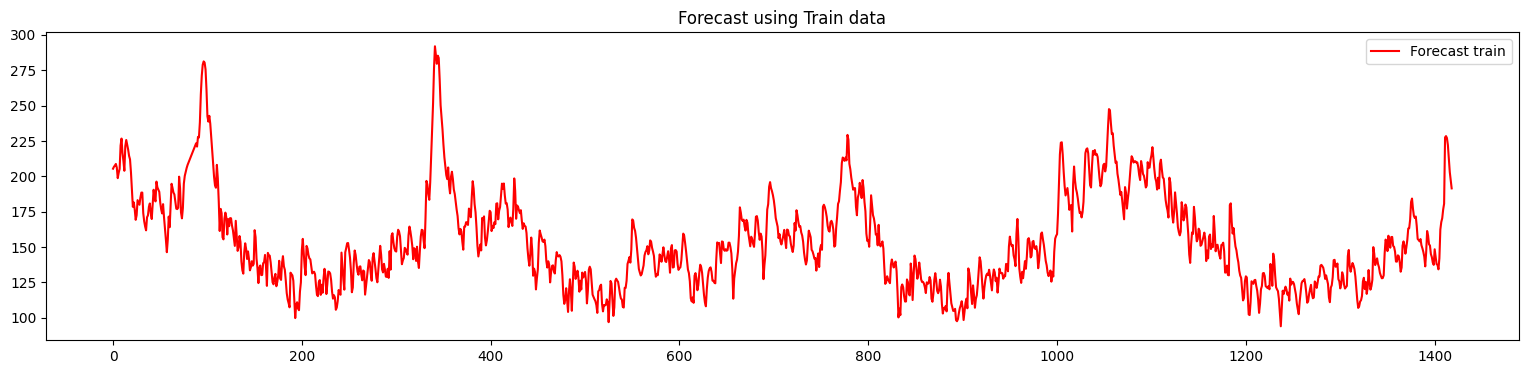

In [105]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_train, trainPredict, 'red')
plt.legend(["Forecast train"])
plt.title("Forecast using Train data")

Text(0.5, 1.0, 'Forecast using test data')

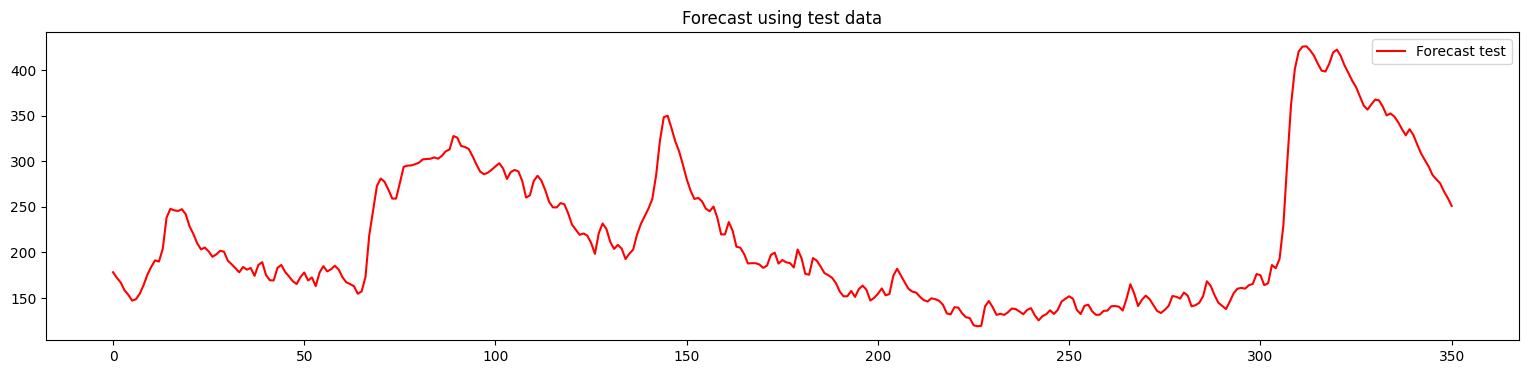

In [106]:
plt.figure(figsize=(19, 4))
#plt.plot(index_test_normal, test_y_normal)
plt.plot(index_test, testPredict, 'red')
plt.legend(["Forecast test"])
plt.title("Forecast using test data")

Shift the predictions

In [107]:
trainPredict.shape

(1419, 1)

In [108]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

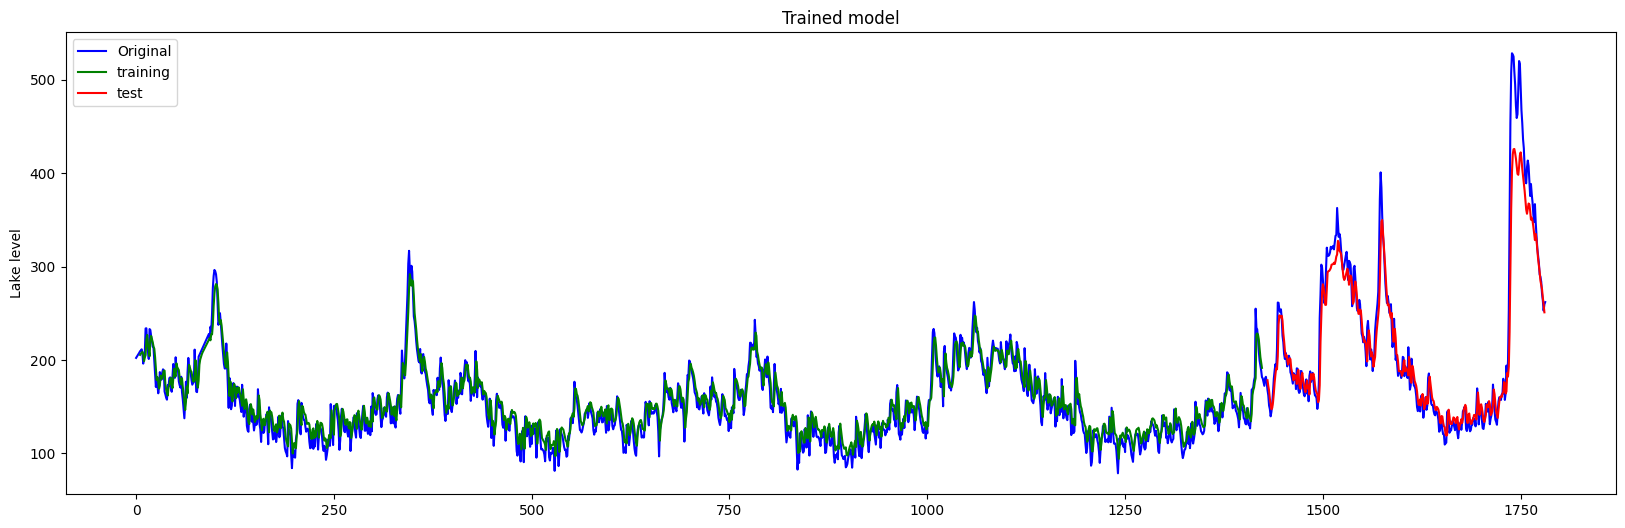

In [109]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

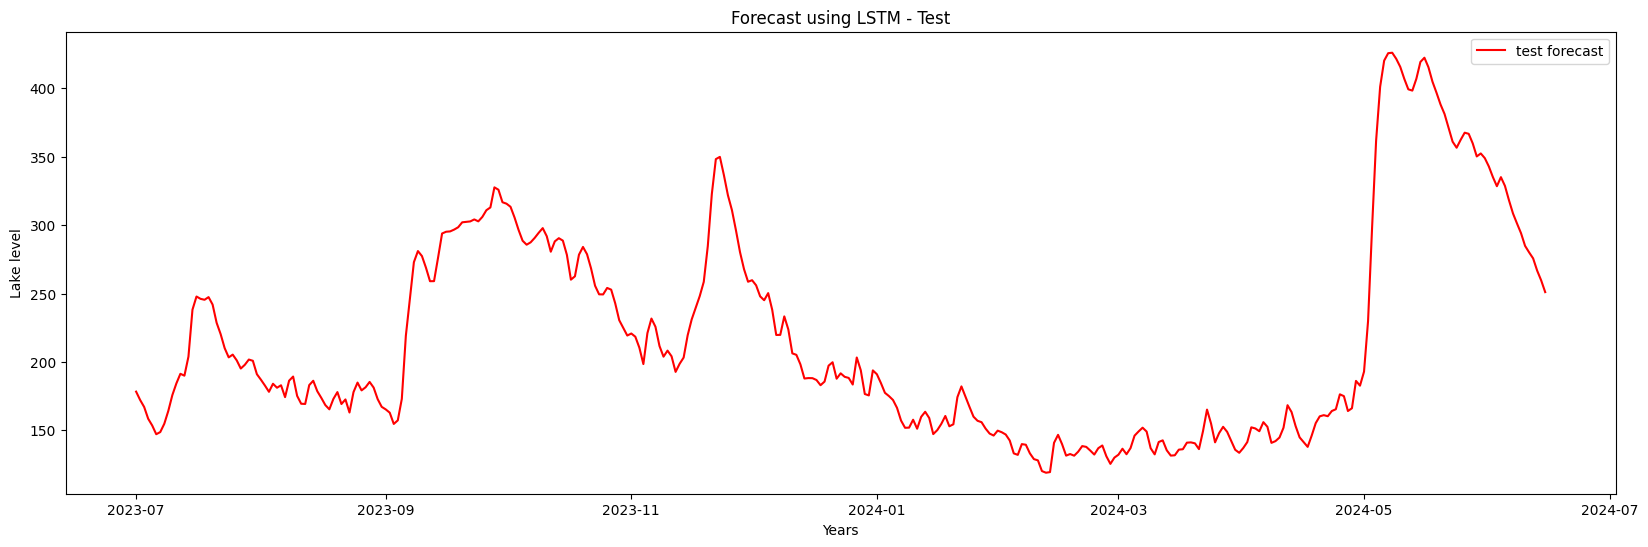

In [110]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(df_daily_mean.index, testPredictPlot, color='red')
plt.legend(["test forecast"])
plt.xlabel("Years")
plt.ylabel("Lake level")
plt.title("Forecast using LSTM - Test")
plt.show()

###Non-stationary data

In [111]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_daily_mean.values)
data_scaled

array([[0.27471866],
       [0.27768258],
       [0.28085491],
       ...,
       [0.38718566],
       [0.40237577],
       [0.4076321 ]])

In [112]:
# split into train and test sets
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size

train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
print("Treino:", len(train))
print("Teste:", len(test))

Treino: 1425
Teste: 357


In [113]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [114]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [115]:
for index in range(5):
    print(trainX[index], trainY[index])

[0.27471866 0.27768258 0.28085491 0.2840967  0.28699115] 0.29064974760339
[0.27768258 0.28085491 0.2840967  0.28699115 0.29064975] 0.2920390867410735
[0.28085491 0.2840967  0.28699115 0.29064975 0.29203909] 0.29516509980086136
[0.2840967  0.28699115 0.29064975 0.29203909 0.2951651 ] 0.28469874496364556
[0.28699115 0.29064975 0.29203909 0.2951651  0.28469874] 0.2611262909276154


In [116]:
print("Train X shape: ", trainX.shape)
print("Train Y shape: ", trainY.shape)

Train X shape:  (1419, 5)
Train Y shape:  (1419,)


In [117]:
print("Test X shape: ", testX.shape)
print("Test Y shape: ", testY.shape)

Test X shape:  (351, 5)
Test Y shape:  (351,)


In [118]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [119]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = Sequential()
model.add(GRU(4, activation='tanh', input_shape=(look_back, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY), callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 4)                   │              84 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1419/1419 - 4s - 3ms/step - loss: 0.0075 - mean_squared_error: 0.0064 - val_loss: 0.0111 - val_mean_squared_error: 0.0104
Epoch 2/20
1419/1419 - 3s - 2ms/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0091 - val_mean_squared_error: 0.0086
Epoch 3/20
1419/1419 - 3s - 2ms/step - loss: 0.0021 - mean_squared_error: 0.0017 - val_loss: 0.0075 - val_mean_squared_error: 0.0072
Epoch 4/20
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0016 - val_loss: 0.0077 - val_mean_squared_error: 0.0074
Epoch 5/20
1419/1419 - 3s - 2ms/step - loss: 0.0019 - mean_squared_error: 0.0016 - val_loss: 0.0069 - val_mean_squared_error: 0.0067
Epoch 6/20
1419/1419 - 3s - 2ms/step - loss: 0.0016 - mean_squared_error: 0.0014 - val_loss: 0.0068 - val_mean_squared_error: 0.0066
Epoch 7/20
1419/1419 - 2s - 2ms/step - loss: 0.0015 - mean_squared_error: 0.0013 - val_loss: 0.0066 - val_mean_squared_error: 0.0064
Epoch 8/20
1419/1419 - 3s - 2ms/step - loss: 0.0016 - mean_squared_er

Predição

In [120]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


invert predictions

In [121]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Shift data

In [122]:
# shift traing predictions for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_scaled)-1, :] = testPredict

Accuracy

In [123]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.29 MSE
Test Score: 25.82 RMSE


####Plot result

In [124]:
def plot_result(dataset, predict, size, title, legend_1, legend_2, color_1 = 'royalblue', color_2 = 'orangered', linestyle_1 = '-', linestyle_2 = '--'):
    plt.figure(figsize=(19, 4))
    plt.plot(dataset.tail(size).index, dataset.tail(size)['level_cm'], color=color_1, linestyle=linestyle_1)
    plt.plot(dataset.tail(size).index, predict[-size:], color=color_2, linestyle=linestyle_2)
    plt.legend([legend_1, legend_2])
    plt.title(title)

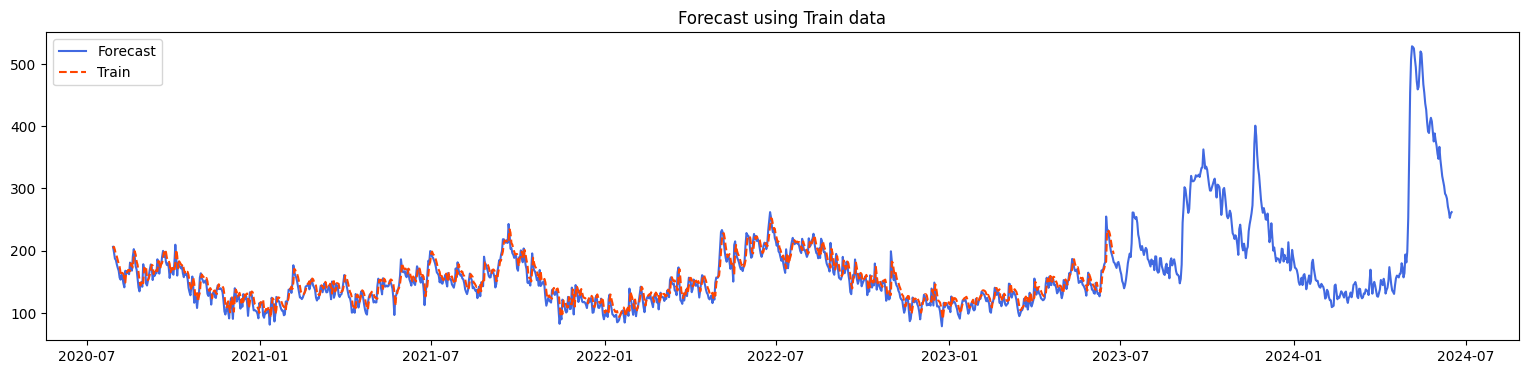

In [125]:
plot_result(df_daily_mean,
            trainPredictPlot,
            trainPredict.shape[0],
            "Forecast using Train data",
            "Forecast",
            "Train")

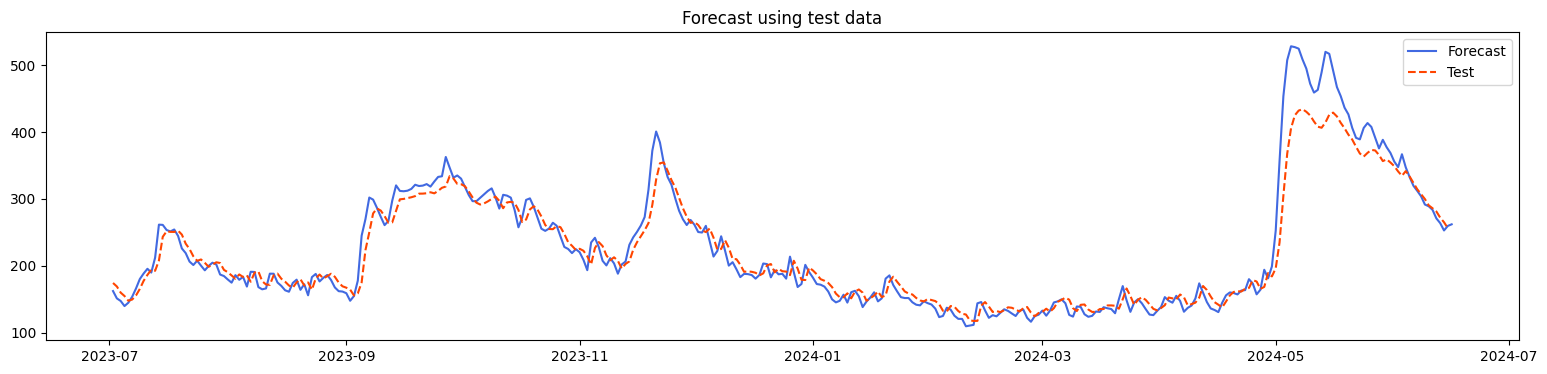

In [126]:
plot_result(df_daily_mean,
            testPredictPlot,
            testPredict.shape[0],
            "Forecast using test data",
            "Forecast",
            "Test")

Shift the predictions

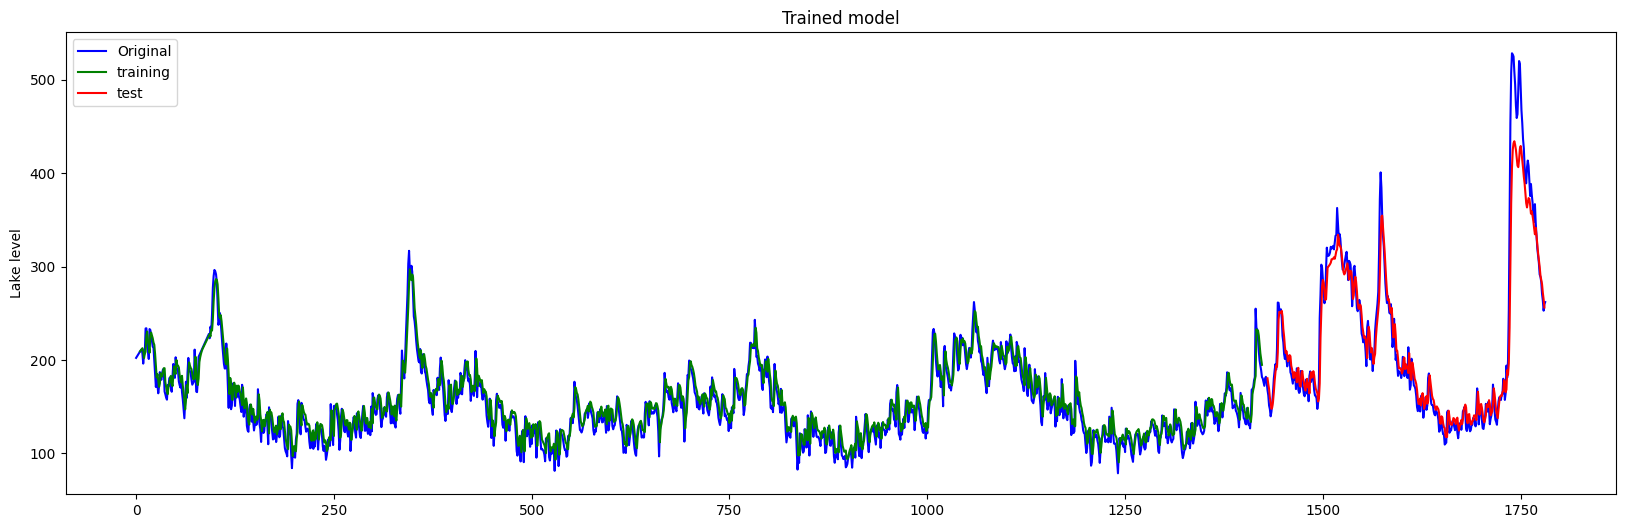

In [127]:
# plot baseline and predictions
plt.figure(figsize=(20, 6))
plt.plot(scaler.inverse_transform(data_scaled), color='blue')
plt.plot(trainPredictPlot, color="green")
plt.plot(testPredictPlot, color='red')
plt.legend(["Original", "training", "test"])
plt.ylabel("Lake level")
plt.title("Trained model")
plt.show()

#Faltando
*   Prophet
*   Montar os comparativos
*   Testar DFTS



